## Using VQGan

This is an state of the art GAN & let's see how to use it.

In [1]:
device = "cuda"

In [2]:
import imitools as I
I.defaults.device = device

## Basic Setup

In [3]:
# # cloning the repo
# !git clone https://github.com/CompVis/taming-transformers &> /dev/null

In [4]:
!pip install -q einops ftfy==6.1.1 regex==2022.4.24 tqdm==4.64.0 omegaconf==2.2.1 pytorch-lightning==1.6.3 &> /dev/null
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

In [5]:
from pathlib import Path
base_data_path = Path.home()/"data/vqgan"
base_data_path.mkdir(exist_ok=True, parents=True)

In [6]:
# # loading imagenet weights
# !cd {base_data_path} && curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
# !cd {base_data_path} && curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

In [7]:
import torch
import torch.nn.functional as F

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply

class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
    f = 2**(model.decoder.num_resolutions - 1)
    toksX, toksY = width // f, height // f
    n_toks = model.quantize.n_e
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
    return z

## Loading & Using the Model

In [8]:
model = load_vqgan_model(base_data_path/'vqgan_imagenet_f16_16384.yaml', base_data_path/'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from /home/data/vqgan/vqgan_imagenet_f16_16384.ckpt


In [9]:
# model

## VQGan Usage

Here we simply trying to encode an image & decode it back.

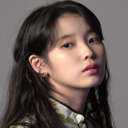

In [11]:
# get the image
im_iu = I.from_path("./images/iu.png").resize(256)
im_iu.resize(128).pil()

In [14]:
encoded,*_ = model.encode(im_iu.cpt().sinrange().pt())
encoded.shape

torch.Size([1, 256, 16, 16])

**It seems like it decode it to some latents space. Let's try to convert it back.**

In [15]:
out = synth(encoded)
out.shape

torch.Size([1, 3, 256, 256])

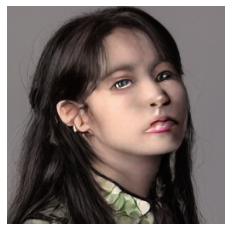

In [18]:
I.wrap(out).show()

**Poor IU. :(**
Imagenet doesn't know well about faces :)

### Let's try with a cat

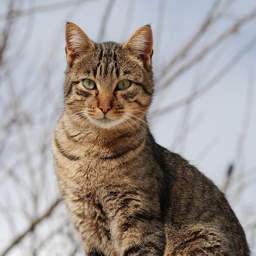

In [19]:
im_cat = I.from_path("images/cat.png").resize(256)
im_cat.pil()

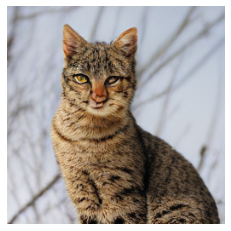

In [21]:
## Let's move through this via the GAN
encoded,*_ = model.encode(im_cat.cpt().sinrange().pt())
out = synth(encoded)
I.wrap(out).show()

**It's a bit better :)**

## Loading some Random Latents to Generate an Image

In [22]:
torch.manual_seed(32)
latents = torch.rand(1, 256, 16, 16) * 2 - 1
latents = latents.to(device)

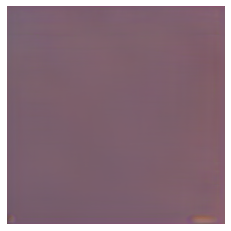

In [23]:
out = synth(latents)
I.wrap(out).show()

**Yep. Almost nothing :)**

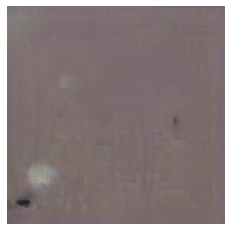

In [24]:
# Let's try this modified random latents generator
latents = rand_z(256, 256)
out = synth(latents)
I.wrap(out).show()

**Okay. a bit better**

## Linear Interpolating

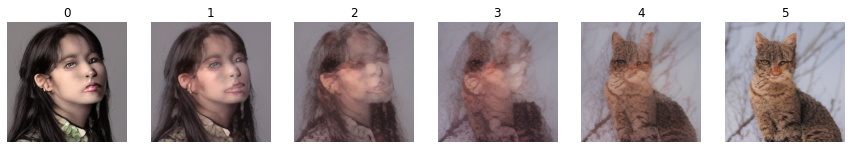

In [25]:
# Let's interpolate between the IU and cat
iu_latents, *_ = model.encode(im_iu.cpt().sinrange().pt())
cat_latents, *_ = model.encode(im_cat.cpt().sinrange().pt())

total_steps = 6
images = []

for step in range(total_steps):
    ratio = step/total_steps
    mixed_latents = cat_latents * ratio + iu_latents * (1-ratio)
    out = synth(mixed_latents)
    images.append(out)

I.wrap(images).show()

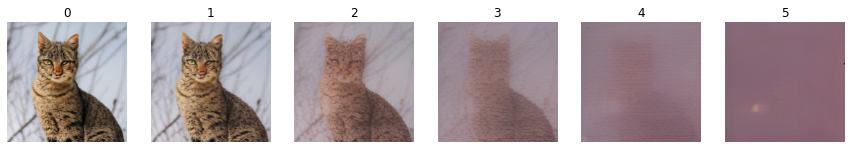

In [26]:
# Let's interpolate between the cat & some random noize

cat_latents, *_ = model.encode(im_cat.cpt().sinrange().pt())
random_latents = rand_z(256, 256)

total_steps = 6
images = []

for step in range(total_steps):
    ratio = step/total_steps
    mixed_latents = random_latents * ratio + cat_latents * (1-ratio)
    out = synth(mixed_latents)
    images.append(out)
    
I.wrap(images).show()

**Yeah. It works pretty well with mixing latents**